# Big Data Analytics Project - Airbnb Pricing Prediction <br>

### Group 63 <br>
André Lourenço - 20240743 <br>
Fábio Dos Santos - 20240678 <br>
Rafael Borges - 20240497 <br>
Rui Reis - 20240854 <br>
Victor Silva - 20240663 

## Table of Contents
- [1. Import Libraries](#1-import-libraries)
- [2. Data Integration](#2-data-integration)
  - [2.1 Data Description](#21-data-description)
- [3. Data Content](#3-data-content)
- [4. Amenities Engineering](#4-amenities-engineering)
- [5. Cluster Analysis](#5-cluster-analysis)
  - [5.1. Host Perspective](#51-host-perspective)
  - [5.2. Amenities Perspective](#52-amenities-perspective)

## 1. Import Libraries

In [0]:
# Pyspark imports
from pyspark.sql.functions import col, split, explode, array, size, array_intersect, udf, from_json, year, to_date, avg, regexp_replace, current_date, datediff, countDistinct, sum, round, when, lit, monotonically_increasing_id, trim
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.ml.functions import vector_to_array
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Other imports
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import numpy as np
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import re

__`Step 1`__ Define a color palette to use in all the following visualizations from NOVA IMS official colors.

In [0]:
main_palette = ["#BED62F", "#5C666C", "#A3B18A", "#D9D9D6", "#3A4F52", "#2E2F2F", "#D4E09B", "#ADC178", "#52796F", "#354F52", "#C6D8AF", "#8C9C92", "#7A9E9F", "#A5A58D", "#6B705C", "#FFEFAF", "#B5838D", "#E5989B", "#A98467", "#B7B7A4"]

## 2. Data Integration

__`Step 2`__ Import the data from our dataset named "Listings" (https://mavenanalytics.io/data-playground?order=number_of_records%2Cdesc).

In [0]:
# File location and type
file_location = "/FileStore/tables/Listings.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

df = spark.read.format("csv") \
    .option("inferSchema", infer_schema) \
    .option("header", "true") \
    .option("sep", ",") \
    .option("quote", '"') \
    .option("escape", '"') \
    .load(file_location)

display(df.limit(5))

listing_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,district,city,latitude,longitude,property_type,room_type,accommodates,bedrooms,amenities,price,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
281420,"Beautiful Flat in le Village Montmartre, Paris",1466919,2011-12-03,"Paris, Ile-de-France, France",null,null,null,f,1,t,f,Buttes-Montmartre,null,Paris,48.88668,2.33343,Entire apartment,Entire place,2,1,"[""Heating"", ""Kitchen"", ""Washer"", ""Wifi"", ""Long term stays allowed""]",53,2,1125,100,10,10,10,10,10,10,f
3705183,39 mÂ² Paris (Sacre CÅ“ur),10328771,2013-11-29,"Paris, Ile-de-France, France",null,null,null,f,1,t,t,Buttes-Montmartre,null,Paris,48.88617,2.34515,Entire apartment,Entire place,2,1,"[""Shampoo"", ""Heating"", ""Kitchen"", ""Essentials"", ""Washer"", ""Dryer"", ""Wifi"", ""Long term stays allowed""]",120,2,1125,100,10,10,10,10,10,10,f
4082273,"Lovely apartment with Terrace, 60m2",19252768,2014-07-31,"Paris, Ile-de-France, France",null,null,null,f,1,t,f,Elysee,null,Paris,48.88112,2.31712,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Kitchen"", ""Washer"", ""Wifi"", ""Long term stays allowed""]",89,2,1125,100,10,10,10,10,10,10,f
4797344,Cosy studio (close to Eiffel tower),10668311,2013-12-17,"Paris, Ile-de-France, France",null,null,null,f,1,t,t,Vaugirard,null,Paris,48.84571,2.30584,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Kitchen"", ""Wifi"", ""Long term stays allowed""]",58,2,1125,100,10,10,10,10,10,10,f
4823489,Close to Eiffel Tower - Beautiful flat : 2 rooms,24837558,2014-12-14,"Paris, Ile-de-France, France",null,null,null,f,1,t,f,Passy,null,Paris,48.855,2.26979,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Hair dryer"", ""Washer"", ""Dryer"", ""Bathtub"", ""Wifi"", ""Elevator"", ""Long term stays allowed"", ""Cable TV""]",60,2,1125,100,10,10,10,10,10,10,f


__`Step 3`__ Due to Databricks Community Edition limitations our project will focus in Paris, therefore we filter our data to Paris.

In [0]:
df = df.where(col("city") == "Paris") 
display(df.limit(10))  
print(f"Rows for Paris: {df.count():,}")

listing_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,district,city,latitude,longitude,property_type,room_type,accommodates,bedrooms,amenities,price,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
281420,"Beautiful Flat in le Village Montmartre, Paris",1466919,2011-12-03,"Paris, Ile-de-France, France",null,null,null,f,1,t,f,Buttes-Montmartre,null,Paris,48.88668,2.33343,Entire apartment,Entire place,2,1,"[""Heating"", ""Kitchen"", ""Washer"", ""Wifi"", ""Long term stays allowed""]",53,2,1125,100,10,10,10,10,10,10,f
3705183,39 mÂ² Paris (Sacre CÅ“ur),10328771,2013-11-29,"Paris, Ile-de-France, France",null,null,null,f,1,t,t,Buttes-Montmartre,null,Paris,48.88617,2.34515,Entire apartment,Entire place,2,1,"[""Shampoo"", ""Heating"", ""Kitchen"", ""Essentials"", ""Washer"", ""Dryer"", ""Wifi"", ""Long term stays allowed""]",120,2,1125,100,10,10,10,10,10,10,f
4082273,"Lovely apartment with Terrace, 60m2",19252768,2014-07-31,"Paris, Ile-de-France, France",null,null,null,f,1,t,f,Elysee,null,Paris,48.88112,2.31712,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Kitchen"", ""Washer"", ""Wifi"", ""Long term stays allowed""]",89,2,1125,100,10,10,10,10,10,10,f
4797344,Cosy studio (close to Eiffel tower),10668311,2013-12-17,"Paris, Ile-de-France, France",null,null,null,f,1,t,t,Vaugirard,null,Paris,48.84571,2.30584,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Kitchen"", ""Wifi"", ""Long term stays allowed""]",58,2,1125,100,10,10,10,10,10,10,f
4823489,Close to Eiffel Tower - Beautiful flat : 2 rooms,24837558,2014-12-14,"Paris, Ile-de-France, France",null,null,null,f,1,t,f,Passy,null,Paris,48.855,2.26979,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Hair dryer"", ""Washer"", ""Dryer"", ""Bathtub"", ""Wifi"", ""Elevator"", ""Long term stays allowed"", ""Cable TV""]",60,2,1125,100,10,10,10,10,10,10,f
4898654,NEW - Charming apartment Le Marais,505535,2011-04-13,"Paris, Ile-de-France, France",null,null,null,f,1,t,t,Temple,null,Paris,48.86428,2.3537,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Washer"", ""Smoke alarm"", ""Wifi"", ""Long term stays allowed"", ""Cable TV""]",95,2,1125,100,10,10,10,10,10,10,f
6021700,2P - Entre Bastille et Republique,8053690,2013-08-09,"Paris, Ile-de-France, France",null,null,null,f,1,t,t,Popincourt,null,Paris,48.86384,2.37101,Entire apartment,Entire place,2,1,"[""Shampoo"", ""TV"", ""Kitchen"", ""Washer"", ""Smoke alarm"", ""Wifi"", ""Fire extinguisher"", ""Long term stays allowed""]",80,2,1125,100,10,10,10,10,10,10,f
6945740,57sqm btw. Bastille & PÃ¨re Lachaise,5924709,2013-04-14,"Paris, Ile-de-France, France",null,null,null,f,1,t,t,Popincourt,null,Paris,48.86043,2.37842,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Washer"", ""Dryer"", ""Smoke alarm"", ""Wifi"", ""Long term stays allowed""]",59,2,1125,100,10,10,10,10,10,10,f
7491966,Charming appartment near the Parc Buttes Chaumont,35812762,2015-06-14,"Paris, Ile-de-France, France",null,null,null,f,1,t,t,Buttes-Chaumont,null,Paris,48.87871,2.37489,Entire apartment,Entire place,2,1,"[""Paid parking off premises"", ""Shampoo"", ""Heating"", ""TV"", ""Iron"", ""Kitchen"", ""Hair dryer"", ""Essentials"", ""Washer"", ""Hot water"", ""Hangers"", ""Smoke alarm"", ""Wifi"", ""Long term stays allowed"", ""Dedicated workspace"", ""Host greets you"", ""Cable TV""]",80,2,1125,100,10,10,10,10,10,10,f
7849932,Bel appartement plein de charme !,20833291,2014-09-02,"Paris, Ile-de-France, France",null,null,null,f,1,t,t,Opera,null,Paris,48.8779,2.33122,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Iron"", ""Kitc

Rows for Paris: 64,690


### 2.1. Data Description

| Feature                       | Description |
|------------------------------|-------------|
| `listing_id`                 | Unique identifier for each Airbnb listing. |
| `name`                       | Title or name of the Airbnb listing, usually provided by the host. |
| `host_id`                    | Unique identifier for the host who owns the listing. |
| `host_since`                 | Date when the host first joined Airbnb. |
| `host_location`              | Location information of the host. |
| `host_response_time`         | Average time the host takes to respond to inquiries. |
| `host_response_rate`         | Percentage of messages the host responds to. |
| `host_acceptance_rate`       | Percentage of booking requests accepted by the host. |
| `host_is_superhost`          | Whether the host is a Superhost. |
| `host_total_listings_count`  | Total number of listings managed by the host. |
| `host_has_profile_pic`       | Whether the host has uploaded a profile picture. |
| `host_identity_verified`     | Whether the host has verified their identity on Airbnb. |
| `neighbourhood`              | Local neighborhood where the listing is located. |
| `district`                   | District where the listing is located. |
| `city`                       | City where the listing is located. |
| `latitude`                   | Latitude coordinate of the listing. |
| `longitude`                  | Longitude coordinate of the listing. |
| `property_type`              | Type of property listed. |
| `room_type`                  | Type of room offered. |
| `accomodates`                | Maximum number of guests the listing can host. |
| `bedrooms`                   | Number of bedrooms available to guests. |
| `amenities`                  | List of amenities offered. |
| `price`                      | Price per night. |
| `minimum_nights`             | Minimum number of nights required per booking. |
| `maximum_nights`             | Maximum number of nights allowed per booking. |
| `review_scores_rating`       | Overall average rating given by guests. |
| `review_scores_accuracy`     | Rating for how accurate the listing description is. |
| `review_scores_cleanliness`  | Rating for the cleanliness of the listing. |
| `review_scores_checkin`      | Rating for the ease and quality of the check-in process. |
| `review_scores_communication`| Rating for communication with the host. |
| `review_scores_location`     | Rating for the listing's location. |
| `review_scores_value`        | Rating for the value for money. |
| `instant_bookable`           | Whether the listing supports instant booking. |

## 3. Data Content

In [0]:
pdf = df.toPandas()
pdf.dtypes

Out[5]: listing_id                       int32
name                            object
host_id                          int32
host_since                      object
host_location                   object
host_response_time              object
host_response_rate             float64
host_acceptance_rate           float64
host_is_superhost               object
host_total_listings_count      float64
host_has_profile_pic            object
host_identity_verified          object
neighbourhood                   object
district                        object
city                            object
latitude                       float64
longitude                      float64
property_type                   object
room_type                       object
accommodates                     int32
bedrooms                       float64
amenities                       object
price                            int32
minimum_nights                   int32
maximum_nights                   int32
review_scores_rat

In [0]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64690 entries, 0 to 64689
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_id                   64690 non-null  int32  
 1   name                         64628 non-null  object 
 2   host_id                      64690 non-null  int32  
 3   host_since                   64657 non-null  object 
 4   host_location                64522 non-null  object 
 5   host_response_time           23346 non-null  object 
 6   host_response_rate           23346 non-null  float64
 7   host_acceptance_rate         31919 non-null  float64
 8   host_is_superhost            64657 non-null  object 
 9   host_total_listings_count    64657 non-null  float64
 10  host_has_profile_pic         64657 non-null  object 
 11  host_identity_verified       64657 non-null  object 
 12  neighbourhood                64690 non-null  object 
 13  district        

#### Conclusions
- The dataset consists of **64,690 observations** and **33 columns**.
- The columns `listing_id`, `host_id`, `accommodates`, `price`, `minimum_nights`, and `maximum_nights` are of type `int32` and contain no missing values.
- Geolocation columns `latitude` and `longitude` are of type `float64` and are fully populated.
- Columns like `host_response_rate`, `host_acceptance_rate`, and several review-related scores are `float64` but have a significant proportion of missing values (e.g., review scores are available in ~48,000 out of 64,690 rows).
- The `bedrooms` column has missing values in approximately **21%** of the entries.
- The `district` column contains **only null values**, making it a candidate for removal unless additional data is sourced.
- Categorical features such as `host_is_superhost`, `host_has_profile_pic`, `host_identity_verified`, `property_type`, `room_type`, and `instant_bookable` are stored as `object` and represent binary or qualitative information.
- The `host_since` column is stored as a `string` (`object`) but represents dates; it should be converted to a `datetime` type for time-based analysis.
- Text-rich columns like `amenities` and `name` are unstructured `object` types and may require parsing or natural language processing (NLP) for advanced insights.
- Overall, the dataset is well-structured, but **data cleaning and type conversion** are needed before deeper exploration or modeling.

## 4. Amenities Engineering

__`Step 4`__ Since there are to many amenities we decide to group them

In [0]:
# Step 1: Clean the string and convert it to an array
df_cleaned = df.withColumn(
    "amenities_array",
    split(
        regexp_replace(col("amenities"), r'[\[\]"]', ''),  # Remove brackets and quotes
        r'\s*,\s*'  # Split by comma
    )
)

# Step 2: Explode the array into individual amenities
exploded_df = df_cleaned.select(explode("amenities_array").alias("amenity"))

# Step 3: Get distinct amenities
unique_amenities = exploded_df.select("amenity").distinct()

# Show result
unique_amenities.show(truncate=False)

+-------------------------+
|amenity                  |
+-------------------------+
|Kitchen                  |
|TV                       |
|Host greets you          |
|Hot water                |
|Iron                     |
|Paid parking off premises|
|Washer                   |
|Hangers                  |
|Bathtub                  |
|Smoke alarm              |
|Dedicated workspace      |
|Elevator                 |
|Heating                  |
|Wifi                     |
|Essentials               |
|Long term stays allowed  |
|Cable TV                 |
|Dryer                    |
|Shampoo                  |
|Fire extinguisher        |
+-------------------------+
only showing top 20 rows



In [0]:
amenity_list = [row['amenity'] for row in unique_amenities.collect()]
print(amenity_list)

['Hot water kettle', 'Dedicated workspace: table', 'Indoor fireplace', 'Keurig coffee machine', 'Free parking garage on premises \\u2013 1 space', 'First aid kit', 'PRO LINE electric stove', 'Kitchen', 'Single level home', 'Denon ; Megaboom sound system with Bluetooth and aux', 'avec congelateur refrigerator', 'Children\\u2019s books and toys', 'and closet', '32\\ HDTV', 'Shared fenced garden or backyard', 'De Dietrich stainless steel oven', 'MIELE oven', 'SMEG induction stove', 'Harman Kardon sound system', 'SMEGG refrigerator', 'Smoking allowed', 'TV', 'Aesop  body soap', 'Outdoor furniture', 'Paid parking garage off premises \\u2013 EUR24 per day', 'Apple  Bluetooth sound system', 'Crib', 'Stainless steel oven', 'Pour-over coffee', 'Yaber v6 Movie Projector with built in Speaker Bluetooth sound system', 'Babysitter recommendations', 'and office chair', 'Host greets you', 'sony sound system', 'Pack \\u2019n Play/travel crib', 'Baby safety gates', 'Paid parking garage on premises \\u2

In [0]:
count = len(amenity_list)
print(f"Total number of amenities: {count}")

Total number of amenities: 747


In [0]:
keywords = ['kettle', 'dedicated workspace table', 'indoor fireplace', 'coffee machine', 'first aid kit', 'stove', 'washerin unit', 'kitchen', 'single level home', 'sound system', 'clothing storage', 'refrigerator', 'garden', 'oven', 'hdtv', 'netflix', 'smoking allowed', 'tv', 'body soap', 'outdoor furniture', 'crib','coffee', 'movie projector', 'babysitter recommendations','host greets you','baby safety gates','pool table', 'air conditioning','parking', 'outlet covers','heating','window guards','waterfront','lake access','bedroom comforts','shampoo','washer','fireplace guards','baby monitor','conditioner','ac unit','extra pillows and blankets','childrens dinnerware','hot water','iron','dryer','childrens books and toys','wifi','game console','barbecue','washer','shower gel','breakfast','baking sheet','cleaning before checkout','patio', 'balcony','pool','self checkin','lockbox','sauna','keypad','hangers','drying rack for clothing','fans','wine glasses','private entrance','dryerin','bathtub','dishes and silverware','microwave','outdoor shower','heater','high chair','safe','beachfront','smoke alarm','pets allowed','fan','ethernet','dining table','dedicated workspace','elevator','laundromat','gym','table corner guards','toaster','cleaning products','hot tub','nespresso machine','ev charger','smart lock','record player','fridge','outdoor dining area','rice maker','essentials','luggage dropoff allowed','carbon monoxide alarm','long term stays allowed','bathroom essentials','dishwasher','freezer','bidet','skiinskiout','building staff','washer in','roomdarkening shades','mosquito net','fire extinguisher','beach essentials','garden or backyard','changing table','cooking basics','piano','bed linens','bbq grill','baby bath','bread maker','childrens books and toys','eletric blinds','rain shower','bikes','wine cellar','gated pproperty','wine cooler','ice machine','board games','suitable for events','decorative fireplace','trash compactor','espresso machine','balcony','dryer in','dual vanity','wet bar','private living room','library','massage bed','office','music system','dvd player','outdoor seating','internet','patio','gated community','video games','sun loungers','spa','ipod dock','game room','steam room','projector','dining area','books','ironing board','lounge area','blender','restaurant','gas grill','smoking parlor','terrace','woodburning fireplace','bluray player','lock on bedroom door','ping pong table','garage','ipad','room service','housekeeping','toiletries','bathrobes','bikes','bed sheets and pillows','selfparking','alarm system','airport shuttle','fitness center','minibar','bar','laundry services','courtyard','concierge','slippers','hammam','bluetooth speaker','printer','turndown service','bottled water','linens','desk','kitchenette','washer','security cameras']


# Step 1: Normalize keywords
normalized_keywords = list(set([
    re.sub(r'[^a-zA-Z\s]', '', kw.lower()).strip()
    for kw in keywords
]))
keyword_set = set(normalized_keywords)

# Step 2: Define the UDF
def map_amenities_to_keywords(amenities):
    if not amenities:
        return []
    
    cleaned = []
    for amenity in amenities:
        normalized = re.sub(r'[^a-zA-Z\s]', '', amenity.lower()).strip()
        for kw in keyword_set:
            if kw in normalized:
                cleaned.append(kw)
                break
    return list(set(cleaned))  # Remove duplicates

map_udf = udf(map_amenities_to_keywords, ArrayType(StringType()))

# Step 3: Parse JSON if needed 
schema = ArrayType(StringType())
df = df.withColumn("amenities_array", from_json(col("amenities"), schema))

# Step 4: Add the cleaned standardized amenities column
df = df.withColumn("standardized_amenities", map_udf(col("amenities_array")))

display(df.limit(5))

listing_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,district,city,latitude,longitude,property_type,room_type,accommodates,bedrooms,amenities,price,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,amenities_array,standardized_amenities,living_entertainment,kitchen_dining,bedroom,bathroom,baby_family,laundry_cleaning,safety_security,outdoor_garden,heating_cooling,travel_access,wellness_leisure,workspace_tech,guest_services,misc_essentials,days_since_host,row_index,row_id
3705183,39 mÂ² Paris (Sacre CÅ“ur),10328771,2013-11-29,"Paris, Ile-de-France, France",null,1.0,0.97,f,1,t,t,Buttes-Montmartre,null,Paris,48.88617,2.34515,Entire apartment,Entire place,2,1,"[""Shampoo"", ""Heating"", ""Kitchen"", ""Essentials"", ""Washer"", ""Dryer"", ""Wifi"", ""Long term stays allowed""]",120,2,1125,100,10,10,10,10,10,10,f,"List(Shampoo, Heating, Kitchen, Essentials, Washer, Dryer, Wifi, Long term stays allowed)","List(washer, wifi, heating, shampoo, essentials, long term stays allowed, dryer, kitchen)",0.0,0.034482758620689655,0.0,0.08333333333333333,0.0,0.2,0.0,0.0,0.1111111111111111,0.1111111111111111,0.0,0.1111111111111111,0.0,0.25,2627,1,0
4823489,Close to Eiffel Tower - Beautiful flat : 2 rooms,24837558,2014-12-14,"Paris, Ile-de-France, France",null,1.0,0.97,f,1,t,f,Passy,null,Paris,48.855,2.26979,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Hair dryer"", ""Washer"", ""Dryer"", ""Bathtub"", ""Wifi"", ""Elevator"", ""Long term stays allowed"", ""Cable TV""]",60,2,1125,100,10,10,10,10,10,10,f,"List(Heating, TV, Kitchen, Essentials, Hair dryer, Washer, Dryer, Bathtub, Wifi, Elevator, Long term stays allowed, Cable TV)","List(washer, wifi, elevator, heating, essentials, tv, long term stays allowed, dryer, bathtub, kitchen)",0.05555555555555555,0.034482758620689655,0.0,0.08333333333333333,0.0,0.2,0.0,0.0,0.1111111111111111,0.1111111111111111,0.0,0.1111111111111111,0.0,0.25,2247,4,1
4898654,NEW - Charming apartment Le Marais,505535,2011-04-13,"Paris, Ile-de-France, France",null,1.0,0.97,f,1,t,t,Temple,null,Paris,48.86428,2.3537,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Washer"", ""Smoke alarm"", ""Wifi"", ""Long term stays allowed"", ""Cable TV""]",95,2,1125,100,10,10,10,10,10,10,f,"List(Heating, TV, Kitchen, Essentials, Washer, Smoke alarm, Wifi, Long term stays allowed, Cable TV)","List(washer, wifi, heating, smoke alarm, essentials, tv, long term stays allowed, kitchen)",0.05555555555555555,0.034482758620689655,0.0,0.0,0.0,0.1,0.07692307692307693,0.0,0.1111111111111111,0.1111111111111111,0.0,0.1111111111111111,0.0,0.25,3588,5,2
6945740,57sqm btw. Bastille & PÃ¨re Lachaise,5924709,2013-04-14,"Paris, Ile-de-France, France",null,1.0,0.97,f,1,t,t,Popincourt,null,Paris,48.86043,2.37842,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Washer"", ""Dryer"", ""Smoke alarm"", ""Wifi"", ""Long term stays allowed""]",59,2,1125,100,10,10,10,10,10,10,f,"List(Heating, TV, Kitchen, Essentials, Washer, Dryer, Smoke alarm, Wifi, Long term stays allowed)","List(washer, wifi, heating, smoke alarm, essentials, tv, long term stays allowed, dryer, kitchen)",0.05555555555555555,0.034482758620689655,0.0,0.0,0.0,0.2,0.07692307692307693,0.0,0.1111111111111111,0.1111111111111111,0.0,0.1111111111111111,0.0,0.25,2856,7,3
7849932,Bel appartement plein de charme !,20833291,2014-09-02,"Paris, Ile-de-France, France",null,1.0,0.97,f,1,t,t,Opera,null,Paris,48.8779,2.33122,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Iron"", ""Kitchen"", ""Essentials"", ""Hair dryer"", ""Washer"", ""Hangers"", ""Wifi"", ""Elevator"", ""Long t

In [0]:
amenity_categories = {
    "living_entertainment": [
        "tv", "hdtv", "netflix", "sound system", "movie projector", "record player",
        "dvd player", "bluray player", "ipod dock", "music system", "books",
        "board games", "game console", "video games", "ping pong table",
        "game room", "lounge area", "projector"
    ],
    "kitchen_dining": [
        "kitchen", "microwave", "oven", "stove", "toaster", "fridge", "refrigerator",
        "freezer", "rice maker", "bread maker", "nespresso machine", "coffee machine",
        "espresso machine", "kettle", "cooking basics", "dishes and silverware",
        "baking sheet", "blender", "dining table", "dining area", "wine glasses",
        "wine cooler", "wine cellar", "gas grill", "bbq grill", "barbecue", "dishwasher",
        "kitchenette", "ice machine"
    ],
    "bedroom": [
        "bed linens", "bedroom comforts", "bed sheets and pillows", "clothing storage",
        "extra pillows and blankets", "hangers", "ironing board", "iron",
        "roomdarkening shades", "linens", "alarm system"
    ],
    "bathroom": [
        "body soap", "shampoo", "conditioner", "shower gel", "bathtub", "bidet",
        "hot water", "bathroom essentials", "toiletries", "dual vanity", "rain shower",
        "bathrobes"
    ],
    "baby_family": [
        "crib", "high chair", "baby bath", "baby monitor", "baby safety gates",
        "childrens books and toys", "childrens dinnerware", "changing table",
        "table corner guards"
    ],
    "laundry_cleaning": [
        "washer", "washerin unit", "washer in", "dryer", "dryerin",
        "drying rack for clothing", "laundromat", "cleaning products",
        "cleaning before checkout", "laundry services"
    ],
    "safety_security": [
        "smoke alarm", "carbon monoxide alarm", "fire extinguisher",
        "fireplace guards", "outlet covers", "window guards", "mosquito net",
        "security cameras", "smart lock", "lockbox", "keypad",
        "lock on bedroom door", "alarm system"
    ],
    "outdoor_garden": [
        "patio", "balcony", "terrace", "garden", "garden or backyard",
        "outdoor furniture", "outdoor dining area", "outdoor seating",
        "outdoor shower", "sun loungers", "beachfront", "lake access",
        "beach essentials", "bikes", "gated community", "gated pproperty", "hammock"
    ],
    "heating_cooling": [
        "air conditioning", "ac unit", "fan", "fans", "heater", "heating",
        "indoor fireplace", "woodburning fireplace", "decorative fireplace"
    ],
    "travel_access": [
        "self checkin", "luggage dropoff allowed", "long term stays allowed",
        "private entrance", "suitable for events", "garage", "parking",
        "selfparking", "airport shuttle"
    ],
    "wellness_leisure": [
        "pool", "sauna", "hot tub", "hammam", "massage bed", "spa", "steam room"
    ],
    "workspace_tech": [
        "dedicated workspace", "dedicated workspace table", "desk", "office",
        "ethernet", "printer", "ipad", "internet", "wifi"
    ],
    "guest_services": [
        "host greets you", "room service", "housekeeping", "turndown service",
        "concierge", "minibar", "bar", "restaurant", "bottled water", "slippers",
        "building staff", "books", "library", "courtyard"
    ],
    "misc_essentials": [
        "essentials", "first aid kit", "pets allowed", "outlet covers"
    ]
}

In [0]:
# Existing category dictionary
amenity_categories_broadcast = sc.broadcast(amenity_categories)

In [0]:
for category, keywords in amenity_categories.items():
    category_col = f"{category}"
    df = df.withColumn(
        category_col,
        size(array_intersect(col("standardized_amenities"), 
                             array([lit(k) for k in keywords]))) / float(len(keywords))
    )


In [0]:

def amenities_preprocess(df):
    # Step 1: Clean the string and convert it to an array
    df_cleaned = df.withColumn(
        "amenities_array",
        split(
            regexp_replace(col("amenities"), r'[\[\]"]', ''),  # Remove brackets and quotes
            r'\s*,\s*'  # Split by comma 
        )
    )

    # Step 2: Explode the array into individual amenities
    exploded_df = df_cleaned.select(explode("amenities_array").alias("amenity"))

    # Step 3: Get distinct amenities 
    unique_amenities = exploded_df.select("amenity").distinct()
    
    # Optional: Collect list and count
    amenity_list = [row['amenity'] for row in unique_amenities.collect()]
    count = len(amenity_list)

    # Keywords list
    keywords = ['kettle', 'dedicated workspace table', 'indoor fireplace', 'coffee machine', 'first aid kit', 'stove', 'washerin unit', 'kitchen', 'single level home', 'sound system', 'clothing storage', 'refrigerator', 'garden', 'oven', 'hdtv', 'netflix', 'smoking allowed', 'tv', 'body soap', 'outdoor furniture', 'crib','coffee', 'movie projector', 'babysitter recommendations','host greets you','baby safety gates','pool table', 'air conditioning','parking', 'outlet covers','heating','window guards','waterfront','lake access','bedroom comforts','shampoo','washer','fireplace guards','baby monitor','conditioner','ac unit','extra pillows and blankets','childrens dinnerware','hot water','iron','dryer','childrens books and toys','wifi','game console','barbecue','washer','shower gel','breakfast','baking sheet','cleaning before checkout','patio', 'balcony','pool','self checkin','lockbox','sauna','keypad','hangers','drying rack for clothing','fans','wine glasses','private entrance','dryerin','bathtub','dishes and silverware','microwave','outdoor shower','heater','high chair','safe','beachfront','smoke alarm','pets allowed','fan','ethernet','dining table','dedicated workspace','elevator','laundromat','gym','table corner guards','toaster','cleaning products','hot tub','nespresso machine','ev charger','smart lock','record player','fridge','outdoor dining area','rice maker','essentials','luggage dropoff allowed','carbon monoxide alarm','long term stays allowed','bathroom essentials','dishwasher','freezer','bidet','skiinskiout','building staff','washer in','roomdarkening shades','mosquito net','fire extinguisher','beach essentials','garden or backyard','changing table','cooking basics','piano','bed linens','bbq grill','baby bath','bread maker','childrens books and toys','eletric blinds','rain shower','bikes','wine cellar','gated pproperty','wine cooler','ice machine','board games','suitable for events','decorative fireplace','trash compactor','espresso machine','balcony','dryer in','dual vanity','wet bar','private living room','library','massage bed','office','music system','dvd player','outdoor seating','internet','patio','gated community','video games','sun loungers','spa','ipod dock','game room','steam room','projector','dining area','books','ironing board','lounge area','blender','restaurant','gas grill','smoking parlor','terrace','woodburning fireplace','bluray player','lock on bedroom door','ping pong table','garage','ipad','room service','housekeeping','toiletries','bathrobes','bikes','bed sheets and pillows','selfparking','alarm system','airport shuttle','fitness center','minibar','bar','laundry services','courtyard','concierge','slippers','hammam','bluetooth speaker','printer','turndown service','bottled water','linens','desk','kitchenette','washer','security cameras']

    # Normalize keywords
    normalized_keywords = list(set([
        re.sub(r'[^a-zA-Z\s]', '', kw.lower()).strip()
        for kw in keywords
    ]))
    keyword_set = set(normalized_keywords)

    # Define UDF
    def map_amenities_to_keywords(amenities):
        if not amenities:
            return []
        cleaned = []
        for amenity in amenities:
            normalized = re.sub(r'[^a-zA-Z\s]', '', amenity.lower()).strip()
            for kw in keyword_set:
                if kw in normalized:
                    cleaned.append(kw)
                    break
        return list(set(cleaned))

    map_udf = udf(map_amenities_to_keywords, ArrayType(StringType()))

    # Parse JSON in amenities column
    schema = ArrayType(StringType())
    df = df.withColumn("amenities_array", from_json(col("amenities"), schema))

    # Add standardized_amenities column
    df = df.withColumn("standardized_amenities", map_udf(col("amenities_array")))

    # Category dictionary
    amenity_categories = {"living_entertainment": [
        "tv", "hdtv", "netflix", "sound system", "movie projector", "record player",
        "dvd player", "bluray player", "ipod dock", "music system", "books",
        "board games", "game console", "video games", "ping pong table",
        "game room", "lounge area", "projector"
    ],
    "kitchen_dining": [
        "kitchen", "microwave", "oven", "stove", "toaster", "fridge", "refrigerator",
        "freezer", "rice maker", "bread maker", "nespresso machine", "coffee machine",
        "espresso machine", "kettle", "cooking basics", "dishes and silverware",
        "baking sheet", "blender", "dining table", "dining area", "wine glasses",
        "wine cooler", "wine cellar", "gas grill", "bbq grill", "barbecue", "dishwasher",
        "kitchenette", "ice machine"
    ],
    "bedroom": [
        "bed linens", "bedroom comforts", "bed sheets and pillows", "clothing storage",
        "extra pillows and blankets", "hangers", "ironing board", "iron",
        "roomdarkening shades", "linens", "alarm system"
    ],
    "bathroom": [
        "body soap", "shampoo", "conditioner", "shower gel", "bathtub", "bidet",
        "hot water", "bathroom essentials", "toiletries", "dual vanity", "rain shower",
        "bathrobes"
    ],
    "baby_family": [
        "crib", "high chair", "baby bath", "baby monitor", "baby safety gates",
        "childrens books and toys", "childrens dinnerware", "changing table",
        "table corner guards"
    ],
    "laundry_cleaning": [
        "washer", "washerin unit", "washer in", "dryer", "dryerin",
        "drying rack for clothing", "laundromat", "cleaning products",
        "cleaning before checkout", "laundry services"
    ],
    "safety_security": [
        "smoke alarm", "carbon monoxide alarm", "fire extinguisher",
        "fireplace guards", "outlet covers", "window guards", "mosquito net",
        "security cameras", "smart lock", "lockbox", "keypad",
        "lock on bedroom door", "alarm system"
    ],
    "outdoor_garden": [
        "patio", "balcony", "terrace", "garden", "garden or backyard",
        "outdoor furniture", "outdoor dining area", "outdoor seating",
        "outdoor shower", "sun loungers", "beachfront", "lake access",
        "beach essentials", "bikes", "gated community", "gated pproperty", "hammock"
    ],
    "heating_cooling": [
        "air conditioning", "ac unit", "fan", "fans", "heater", "heating",
        "indoor fireplace", "woodburning fireplace", "decorative fireplace"
    ],
    "travel_access": [
        "self checkin", "luggage dropoff allowed", "long term stays allowed",
        "private entrance", "suitable for events", "garage", "parking",
        "selfparking", "airport shuttle"
    ],
    "wellness_leisure": [
        "pool", "sauna", "hot tub", "hammam", "massage bed", "spa", "steam room"
    ],
    "workspace_tech": [
        "dedicated workspace", "dedicated workspace table", "desk", "office",
        "ethernet", "printer", "ipad", "internet", "wifi"
    ],
    "guest_services": [
        "host greets you", "room service", "housekeeping", "turndown service",
        "concierge", "minibar", "bar", "restaurant", "bottled water", "slippers",
        "building staff", "books", "library", "courtyard"
    ],
    "misc_essentials": [
        "essentials", "first aid kit", "pets allowed", "outlet covers"
    ]
    }

    # Broadcast categories using global sc
    amenity_categories_broadcast = sc.broadcast(amenity_categories)

    # Add category columns
    for category, keywords in amenity_categories.items():
        df = df.withColumn(
            category,
            size(array_intersect(col("standardized_amenities"),
                                 array([lit(k) for k in keywords]))) / float(len(keywords))
        )

    return df

df = amenities_preprocess(df)

## 5. Cluster Analysis

__`Step 5`__ Conduct a Cluster Analysis based on the host perspective

### 5.1 Host Perspective

#### 5.1.1 Cluster 

In [0]:
from pyspark.sql.functions import col, datediff, max as spark_max

# Get the max date from host_since
max_date = df.select(spark_max("host_since").alias("max_date")).collect()[0]["max_date"]

# Subtract host_since from max_date to get days since
df = df.withColumn("days_since_host", datediff(lit(max_date), col("host_since")))

In [0]:
host_cluster_columns = ["host_response_rate", "host_acceptance_rate", "host_total_listings_count", "days_since_host", "review_scores_rating"]
host_cluster_columns

Out[17]: ['host_response_rate',
 'host_acceptance_rate',
 'host_total_listings_count',
 'days_since_host',
 'review_scores_rating']

- Fill missing values with the mean - Host perspective

In [0]:
# Impute each column with its median
for col_name in host_cluster_columns:
    # Calculate approximate median (50th percentile)
    median_val = df.approxQuantile(col_name, [0.5], 0.01)[0]
    
    # Fill missing values with the median
    df = df.fillna({col_name: median_val})

In [0]:
display(df.select([sum(col(c).isNull().cast("int")).alias(c) for c in host_cluster_columns]))

host_response_rate,host_acceptance_rate,host_total_listings_count,days_since_host,review_scores_rating
0,0,0,0,0


We can see that the features that are going to be used for the host clustering have a lots of missing values. Lets see the plots of theses features to see if we are going to input them if the mean of average

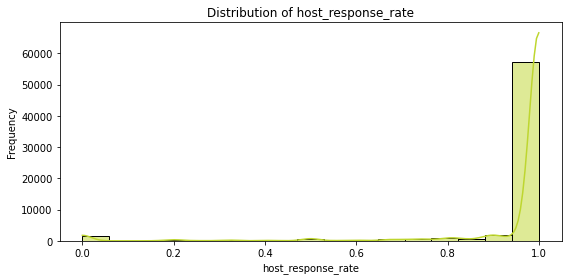

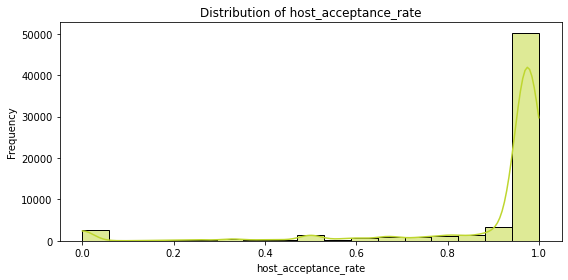

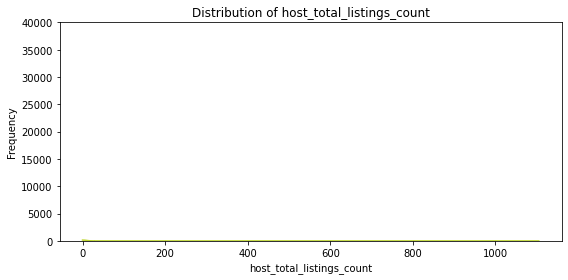

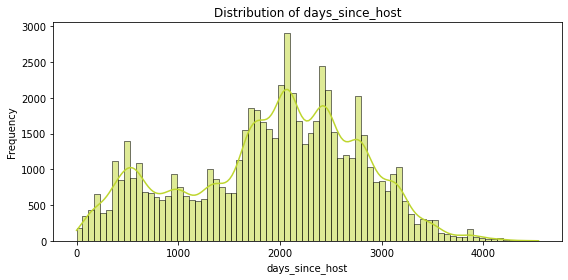

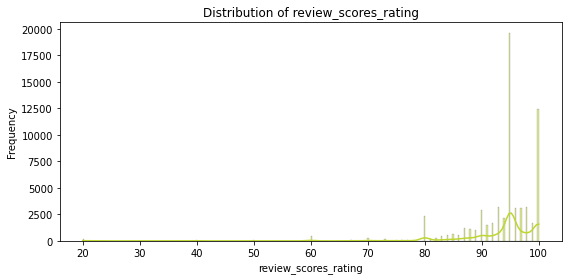

In [0]:
# Collect relevant data to Pandas DataFrame
host_df = df.select(host_cluster_columns).toPandas()

# Plot distribution for each column

for col_name in host_cluster_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=host_df, x=col_name, kde=True,color=main_palette[0])
    plt.title(f'Distribution of {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

Since the distributions of the columns are not normal, and a litlle bit skewed we are going to use the median to do the imputation

In [0]:
display(df.select([sum(col(c).isNull().cast("int")).alias(c) for c in host_cluster_columns]))

host_response_rate,host_acceptance_rate,host_total_listings_count,days_since_host,review_scores_rating
0,0,0,0,0


In [0]:
# Assemble selected columns into a features vector
assembler = VectorAssembler(inputCols=host_cluster_columns, outputCol="features")
df_vector = assembler.transform(df)

# Apply MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

# Convert scaled vector to array and unpack into individual columns
df_scaled_array = df_scaled.withColumn("scaled_array", vector_to_array("scaled_features"))

# Select only the scaled columns
for i, col_name in enumerate(host_cluster_columns):
    df_scaled_array = df_scaled_array.withColumn(f"{col_name}_scaled", col("scaled_array")[i])

# Keep only the new scaled columns
scaled_column_names = [f"{col_name}_scaled" for col_name in host_cluster_columns]
df_host_scaled = df_scaled_array.select(scaled_column_names)

In [0]:
# Reassemble scaled columns into a single vector for clustering
assembler_final = VectorAssembler(inputCols=scaled_column_names, outputCol="scaled_features")
df_cluster_ready = assembler_final.transform(df_host_scaled)

In [0]:
display(df_cluster_ready.limit(5))

host_response_rate_scaled,host_acceptance_rate_scaled,host_total_listings_count_scaled,days_since_host_scaled,review_scores_rating_scaled,scaled_features
1.0,0.97,9.049773755656109E-4,0.7381161971830986,1.0,"Map(vectorType -> dense, length -> 5, values -> List(1.0, 0.97, 9.049773755656109E-4, 0.7381161971830986, 1.0))"
1.0,0.97,9.049773755656109E-4,0.578125,1.0,"Map(vectorType -> dense, length -> 5, values -> List(1.0, 0.97, 9.049773755656109E-4, 0.578125, 1.0))"
1.0,0.97,9.049773755656109E-4,0.5244278169014085,1.0,"Map(vectorType -> dense, length -> 5, values -> List(1.0, 0.97, 9.049773755656109E-4, 0.5244278169014085, 1.0))"
1.0,0.97,9.049773755656109E-4,0.5741637323943662,1.0,"Map(vectorType -> dense, length -> 5, values -> List(1.0, 0.97, 9.049773755656109E-4, 0.5741637323943662, 1.0))"
1.0,0.97,9.049773755656109E-4,0.49449823943661975,1.0,"Map(vectorType -> dense, length -> 5, values -> List(1.0, 0.97, 9.049773755656109E-4, 0.49449823943661975, 1.0))"


k=2: Silhouette=0.7731, WSSSE=5786.95
k=3: Silhouette=0.3816, WSSSE=5153.50
k=4: Silhouette=0.5903, WSSSE=3010.28
k=5: Silhouette=0.5953, WSSSE=2690.03
k=6: Silhouette=0.4744, WSSSE=2421.53
k=7: Silhouette=0.4613, WSSSE=2016.77
k=8: Silhouette=0.5107, WSSSE=1880.27
k=9: Silhouette=0.4116, WSSSE=1772.10
k=10: Silhouette=0.3785, WSSSE=1746.55


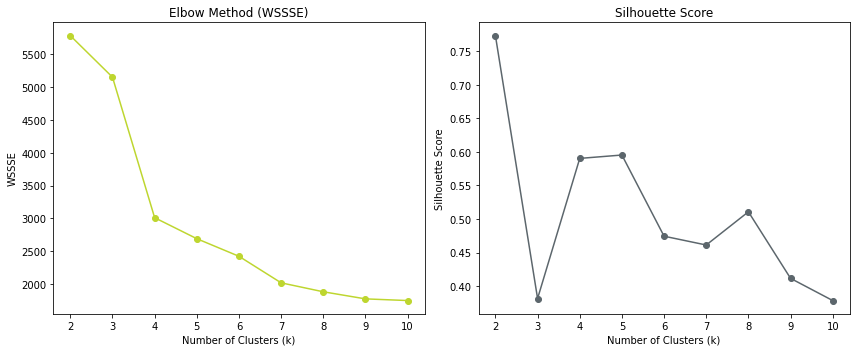

In [0]:

from pyspark.ml.clustering import KMeans

silhouette_scores = []
wssse_scores = []
k_values = list(range(2, 11))

for k in k_values:
    kmeans = KMeans(featuresCol="scaled_features", k=k, seed=42)
    model = kmeans.fit(df_cluster_ready)
    predictions = model.transform(df_cluster_ready)

    evaluator = ClusteringEvaluator(featuresCol="scaled_features", metricName="silhouette")
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    
    wssse = model.summary.trainingCost
    wssse_scores.append(wssse)
    
    print(f"k={k}: Silhouette={silhouette:.4f}, WSSSE={wssse:.2f}")

# Plot Elbow + Silhouette
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

plt.plot(k_values, wssse_scores, marker='o',color=main_palette[0])
plt.title("Elbow Method (WSSSE)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WSSSE")

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o',color=main_palette[1])
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

In [0]:
# Initialize and train KMeans with 4 clusters
kmeans = KMeans(featuresCol="scaled_features", k=4, seed=42)
model = kmeans.fit(df_cluster_ready)

# Make predictions (assign clusters)
df_clustered = model.transform(df_cluster_ready)

In [0]:
# List of scaled columns
scaled_columns = [
    "host_response_rate_scaled",
    "host_acceptance_rate_scaled",
    "host_total_listings_count_scaled",
    "days_since_host_scaled",
    "review_scores_rating_scaled"
]

# Group by prediction and compute average for each feature
agg_exprs = [F.avg(c).alias(c) for c in scaled_columns]
cluster_means_df = df_clustered.groupBy("prediction").agg(*agg_exprs)
display(cluster_means_df)

prediction,host_response_rate_scaled,host_acceptance_rate_scaled,host_total_listings_count_scaled,days_since_host_scaled,review_scores_rating_scaled
1,0.9884220659205233,0.9558910052366544,0.012159001523473554,0.5258719909171655,0.9251103809426047
3,0.14926315789473701,0.6959172932330852,0.022290681454768084,0.40094903301387375,0.9014144736842107
2,0.9551146384479716,0.2463668430335099,0.005003001517162734,0.47736591013847146,0.934261708798746
0,0.9807884925713634,0.9565616827110168,0.007147412711933455,0.1897948014445803,0.9059296922820088


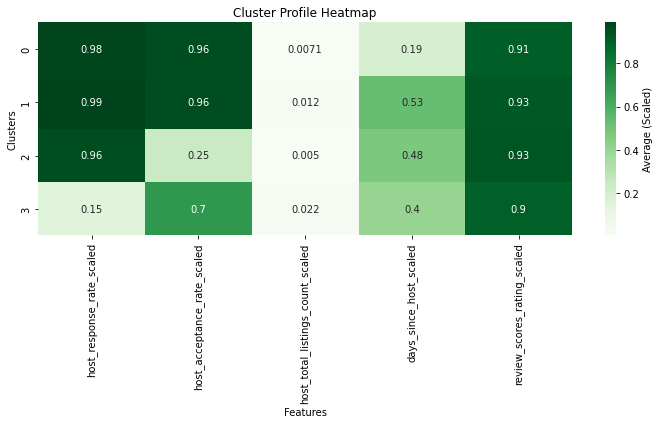

In [0]:
pdf_means = cluster_means_df.toPandas().set_index("prediction").sort_index()

# Plot heatmap with custom cmap
plt.figure(figsize=(10, 6))
sns.heatmap(pdf_means, annot=True, cmap="Greens", cbar_kws={"label": "Average (Scaled)"})
plt.title("Cluster Profile Heatmap")
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.tight_layout()
plt.show()

##### 📊 Cluster Analysis Summary (Updated Heatmap)

This analysis segments hosts into 4 clusters using scaled feature values. A heatmap reveals distinct behavioral patterns.

#### 🔍 Features Used:
- `host_response_rate_scaled`: Speed and reliability of response
- `host_acceptance_rate_scaled`: Likelihood of accepting booking requests
- `host_total_listings_count_scaled`: Number of listings the host manages
- `days_since_host_scaled`: Hosting experience (how long they've been active)
- `review_scores_rating_scaled`: Overall rating score from guest reviews

---

#### ✅ Cluster Profiles:

| Cluster | Host Type                         | Strengths                               | Weaknesses                              |
|---------|-----------------------------------|-----------------------------------------|------------------------------------------|
| **0**   | New, responsive high-performers   | High response & acceptance, high rating | New to hosting (less experienced)        |
| **1**   | Experienced ideal hosts           | Best scores across all features         | None significant                         |
| **2**   | Selective communicators           | High ratings, okay experience           | Low acceptance rate                      |
| **3**   | Inconsistent responders           | Decent ratings and acceptance           | Very low response rate                   |

---

#### 📌 Cluster Descriptions

##### **Cluster 0**
- 💬 **Response Rate**: 0.98  
- ✅ **Acceptance Rate**: 0.96  
- 📦 **Listings**: Very low (0.0071)  
- 🕒 **Experience**: Low (0.19)  
- ⭐ **Rating**: 0.91  
→ **Conclusion**: New, highly responsive hosts who provide great guest experience despite being new.

---

##### **Cluster 1**
- 💬 **Response Rate**: 0.99  
- ✅ **Acceptance Rate**: 0.96  
- 📦 **Listings**: Low (0.012)  
- 🕒 **Experience**: High (0.53)  
- ⭐ **Rating**: 0.93  
→ **Conclusion**: Most experienced, highly rated hosts. Ideal all-around performers.

---

##### **Cluster 2**
- 💬 **Response Rate**: 0.96  
- ❌ **Acceptance Rate**: 0.25  
- 📦 **Listings**: Very low (0.005)  
- 🕒 **Experience**: Moderate (0.48)  
- ⭐ **Rating**: 0.93  
→ **Conclusion**: Communicative and experienced hosts who are very selective in accepting bookings.

---

##### **Cluster 3**
- 💬 **Response Rate**: 0.15  
- ✅ **Acceptance Rate**: 0.70  
- 📦 **Listings**: Slightly higher (0.022)  
- 🕒 **Experience**: Moderate (0.40)  
- ⭐ **Rating**: 0.90  
→ **Conclusion**: Hosts who are somewhat experienced but slow to respond. May need improvement in responsiveness.

---


__`Step 6`__ Use non-metrical features to help understand the profile of these clusters

#### 5.1.2 Cluster Profiling

In [0]:
# Add row index to both DataFrames
df = df.withColumn("row_index", monotonically_increasing_id())
df_cluster = df_clustered.withColumn("row_index", monotonically_increasing_id())

# Join on the index
df_combined = df.join(df_cluster.select("row_index", "prediction"), on="row_index", how="inner")

# Drop the temporary index column
df_combined = df_combined.drop("row_index")

display(df_combined.limit(5))

listing_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,district,city,latitude,longitude,property_type,room_type,accommodates,bedrooms,amenities,price,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,amenities_array,standardized_amenities,living_entertainment,kitchen_dining,bedroom,bathroom,baby_family,laundry_cleaning,safety_security,outdoor_garden,heating_cooling,travel_access,wellness_leisure,workspace_tech,guest_services,misc_essentials,days_since_host,row_id,prediction
3705183,39 mÂ² Paris (Sacre CÅ“ur),10328771,2013-11-29,"Paris, Ile-de-France, France",null,1.0,0.97,f,1,t,t,Buttes-Montmartre,null,Paris,48.88617,2.34515,Entire apartment,Entire place,2,1,"[""Shampoo"", ""Heating"", ""Kitchen"", ""Essentials"", ""Washer"", ""Dryer"", ""Wifi"", ""Long term stays allowed""]",120,2,1125,100,10,10,10,10,10,10,f,"List(Shampoo, Heating, Kitchen, Essentials, Washer, Dryer, Wifi, Long term stays allowed)","List(washer, wifi, heating, shampoo, essentials, long term stays allowed, dryer, kitchen)",0.0,0.034482758620689655,0.0,0.08333333333333333,0.0,0.2,0.0,0.0,0.1111111111111111,0.1111111111111111,0.0,0.1111111111111111,0.0,0.25,2627,0,1
4823489,Close to Eiffel Tower - Beautiful flat : 2 rooms,24837558,2014-12-14,"Paris, Ile-de-France, France",null,1.0,0.97,f,1,t,f,Passy,null,Paris,48.855,2.26979,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Hair dryer"", ""Washer"", ""Dryer"", ""Bathtub"", ""Wifi"", ""Elevator"", ""Long term stays allowed"", ""Cable TV""]",60,2,1125,100,10,10,10,10,10,10,f,"List(Heating, TV, Kitchen, Essentials, Hair dryer, Washer, Dryer, Bathtub, Wifi, Elevator, Long term stays allowed, Cable TV)","List(washer, wifi, elevator, heating, essentials, tv, long term stays allowed, dryer, bathtub, kitchen)",0.05555555555555555,0.034482758620689655,0.0,0.08333333333333333,0.0,0.2,0.0,0.0,0.1111111111111111,0.1111111111111111,0.0,0.1111111111111111,0.0,0.25,2247,1,1
4898654,NEW - Charming apartment Le Marais,505535,2011-04-13,"Paris, Ile-de-France, France",null,1.0,0.97,f,1,t,t,Temple,null,Paris,48.86428,2.3537,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Washer"", ""Smoke alarm"", ""Wifi"", ""Long term stays allowed"", ""Cable TV""]",95,2,1125,100,10,10,10,10,10,10,f,"List(Heating, TV, Kitchen, Essentials, Washer, Smoke alarm, Wifi, Long term stays allowed, Cable TV)","List(washer, wifi, heating, smoke alarm, essentials, tv, long term stays allowed, kitchen)",0.05555555555555555,0.034482758620689655,0.0,0.0,0.0,0.1,0.07692307692307693,0.0,0.1111111111111111,0.1111111111111111,0.0,0.1111111111111111,0.0,0.25,3588,2,1
6945740,57sqm btw. Bastille & PÃ¨re Lachaise,5924709,2013-04-14,"Paris, Ile-de-France, France",null,1.0,0.97,f,1,t,t,Popincourt,null,Paris,48.86043,2.37842,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Washer"", ""Dryer"", ""Smoke alarm"", ""Wifi"", ""Long term stays allowed""]",59,2,1125,100,10,10,10,10,10,10,f,"List(Heating, TV, Kitchen, Essentials, Washer, Dryer, Smoke alarm, Wifi, Long term stays allowed)","List(washer, wifi, heating, smoke alarm, essentials, tv, long term stays allowed, dryer, kitchen)",0.05555555555555555,0.034482758620689655,0.0,0.0,0.0,0.2,0.07692307692307693,0.0,0.1111111111111111,0.1111111111111111,0.0,0.1111111111111111,0.0,0.25,2856,3,1
7849932,Bel appartement plein de charme !,20833291,2014-09-02,"Paris, Ile-de-France, France",null,1.0,0.97,f,1,t,t,Opera,null,Paris,48.8779,2.33122,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Iron"", ""Kitchen"", ""Essentials"", ""Hair dryer"", ""Washer"", ""Hangers"", ""Wifi"", ""Elevator"", ""Long 

##### Cluster Size

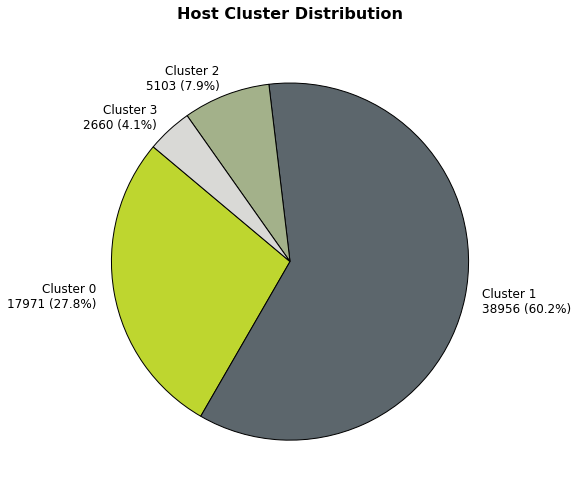

In [0]:
# Step 1: Group and count clusters
cluster_counts = df_combined.groupBy("prediction").count().orderBy("prediction")
pdf = cluster_counts.toPandas()

# Step 2: Prepare labels with both % and count
total = pdf['count'].sum()
labels = [f"Cluster {row['prediction']}\n{row['count']} ({row['count'] / total:.1%})" for _, row in pdf.iterrows()]

# Step 3: Plot with improved layout
colors = plt.cm.Set3.colors 

plt.figure(figsize=(8, 8))
plt.pie(pdf['count'], labels=labels, colors=main_palette, startangle=140, wedgeprops={'edgecolor': 'black'}, textprops={'fontsize': 12})
plt.title("Host Cluster Distribution", fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

Cluster 0 and cluster 1 are the most predominant ones 

##### Cluster vs Price

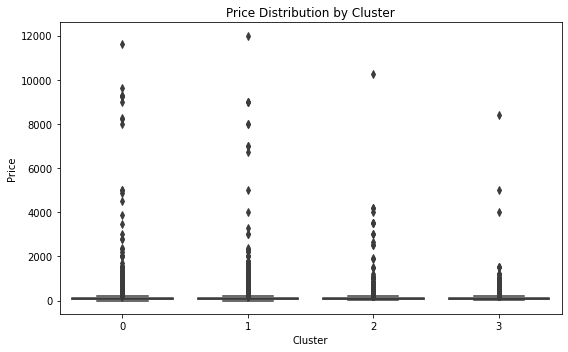

In [0]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='prediction', y='price', data= df_combined.toPandas(),palette=main_palette)
plt.title('Price Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Price')
plt.tight_layout()
plt.show()


- Most listings across all clusters have similar median prices.
- Outliers (very high prices) are present in every cluster, not just among superhosts or experienced hosts.
- Clustering by host behavior does **not strongly correlate** with price.


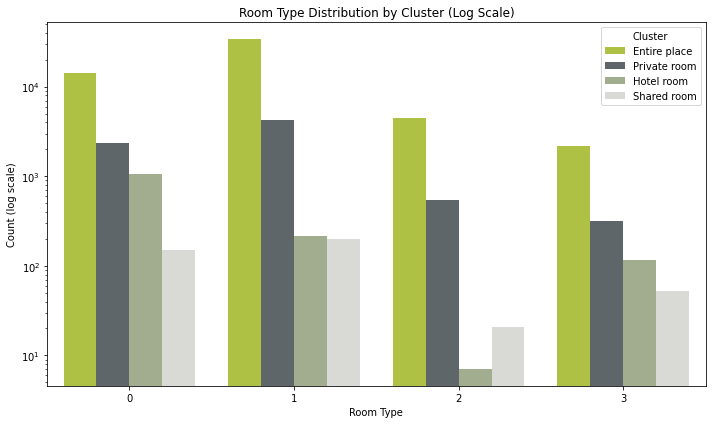

In [0]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_combined.toPandas(), x='prediction', hue='room_type',palette=main_palette)
plt.yscale('log') 
plt.title('Room Type Distribution by Cluster (Log Scale)')
plt.xlabel('Room Type')
plt.ylabel('Count (log scale)')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


Entire Place is always the option that is the most choosen

- **Cluster 0 (New, responsive)**: Mix of entire places, private rooms, and the most hotel rooms. New but behave professionally.
- **Cluster 1 (Experienced, ideal hosts)**: Strong preference for entire places. Most consistent and high-quality offerings.
- **Cluster 2 (Selective communicators)**: Low volume overall. Mostly private rooms, few budget or shared options.
- **Cluster 3 (Inconsistent responders)**: Most balanced mix, including shared rooms. Possibly casual or budget-focused hosts.

> ✅ Hosts with better performance (Clusters 0 and 1) tend to offer **entire places**, while lower-performing or less responsive hosts (Cluster 3) offer a **broader, budget-oriented mix**.




##### SuperHost % by Cluster

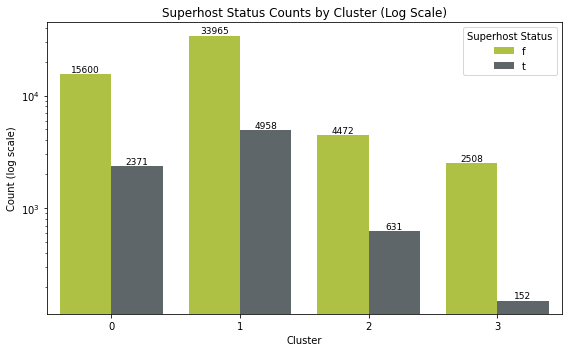

In [0]:
# Count 't' and 'f' per cluster
superhost_counts = (
    df_combined.groupBy("prediction", "host_is_superhost")
              .count()
              .orderBy("prediction", "host_is_superhost")
)

# Convert to Pandas
pdf_counts = superhost_counts.toPandas()

# Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=pdf_counts, x='prediction', y='count', hue='host_is_superhost', palette=main_palette)
plt.yscale("log")
plt.title('Superhost Status Counts by Cluster (Log Scale)')
plt.xlabel('Cluster')
plt.ylabel('Count (log scale)')

# Add count labels
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title='Superhost Status')

plt.tight_layout()
plt.show()

- All clusters have more **normal hosts** than **superhosts**.
- **Cluster 3** stands out, with a significantly higher number of normal hosts compared to superhosts.  
  This may indicate that this cluster represents **inconsistent or less professional hosts**.


##### Host Location by Cluster

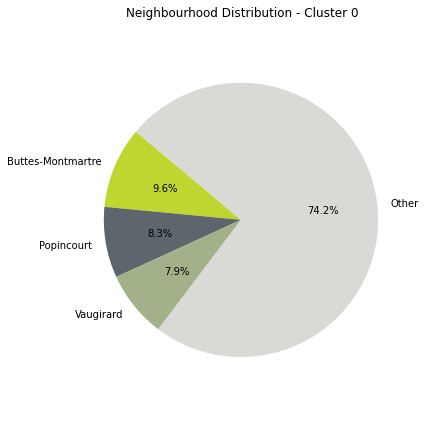

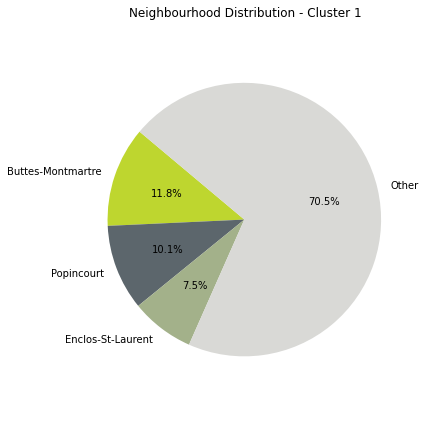

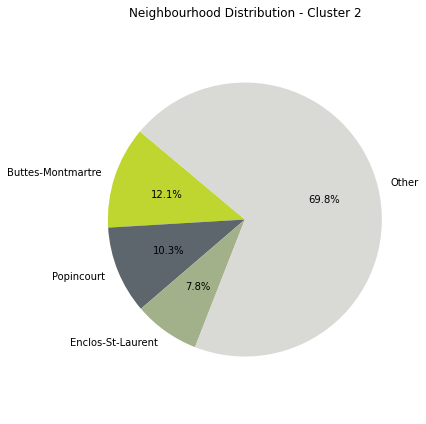

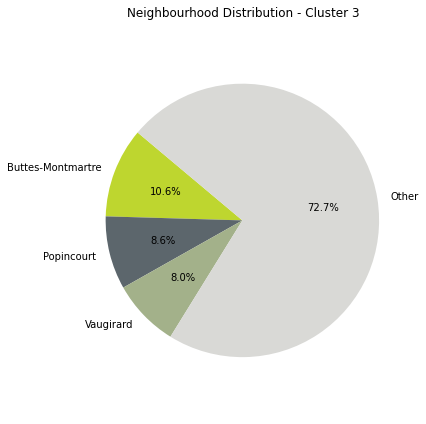

In [0]:
# Get unique cluster IDs
cluster_ids = sorted(df_combined.toPandas()['prediction'].unique())

# Create one pie chart per cluster
for cluster in cluster_ids:
    # Filter data for the cluster
    cluster_data = df_combined.toPandas()[df_combined.toPandas()['prediction'] == cluster]
    
    # Count neighbourhoods
    neighbourhood_counts = cluster_data['neighbourhood'].value_counts().nlargest(3) 
    other_count = cluster_data.shape[0] - neighbourhood_counts.sum()
    
    # Add "Other" if needed
    if other_count > 0:
        neighbourhood_counts['Other'] = other_count

    # Plot
    plt.figure(figsize=(6, 6))
    plt.pie(
        neighbourhood_counts.values,
        labels=neighbourhood_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=main_palette
    )
    plt.title(f'Neighbourhood Distribution - Cluster {cluster}')
    plt.axis('equal') 
    plt.tight_layout()
    plt.show()

- **Buttes-Montmartre** is the most common neighbourhood across **all clusters**.
- **Popincourt** consistently ranks as the **second most frequent** neighbourhood.
- The third place varies slightly:
  - **Vaugirard** appears third in **Clusters 0 and 3**
  - **Enclos-St-Laurent** appears third in **Clusters 1 and 2**
- Overall, neighbourhood distribution is quite similar across clusters, suggesting that **location does not strongly differentiate host behavior clusters**.


##### Photo ID and Identity Verification by Cluster

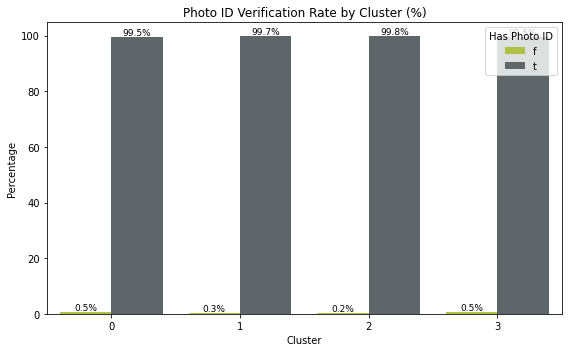

In [0]:
# Step 1: Group and count
photo_id_counts = (
    df_combined.toPandas().groupby(['prediction', 'host_has_profile_pic'])
       .size()
       .reset_index(name='count')
)

# Step 2: Convert to percentage within each cluster
photo_id_percent = (
    photo_id_counts
    .groupby('prediction')
    .apply(lambda x: x.assign(percent=x['count'] / x['count'].sum() * 100))
    .reset_index(drop=True)
)

# Step 3: Plot as percentage
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=photo_id_percent, x='prediction', y='percent', hue='host_has_profile_pic',palette=main_palette)
plt.title('Photo ID Verification Rate by Cluster (%)')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
ax.legend(title='Has Photo ID')

# Add percentage labels
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


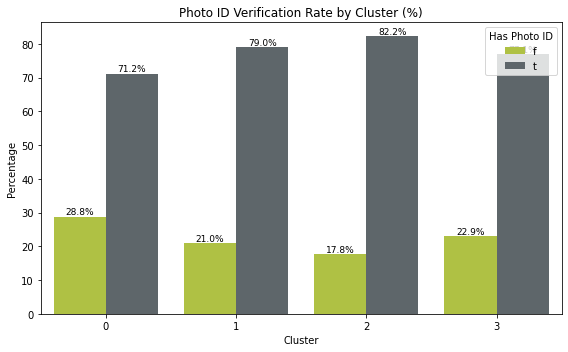

In [0]:
# Step 1: Group and count
photo_id_counts = (
    df_combined.toPandas().groupby(['prediction', 'host_identity_verified'])
       .size()
       .reset_index(name='count')
)

# Step 2: Convert to percentage within each cluster
photo_id_percent = (
    photo_id_counts
    .groupby('prediction')
    .apply(lambda x: x.assign(percent=x['count'] / x['count'].sum() * 100))
    .reset_index(drop=True)
)

# Step 3: Plot as percentage
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=photo_id_percent, x='prediction', y='percent', hue='host_identity_verified',palette=main_palette)
plt.title('Photo ID Verification Rate by Cluster (%)')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
ax.legend(title='Has Photo ID')

# Add percentage labels
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

- Both features — **profile photo** and **ID verification** — appear to have **limited importance** in distinguishing between clusters.
- In all clusters, the majority of hosts have a profile photo.
- Similarly, the distribution of ID verification status is **very similar across clusters**.
- Therefore, these features do **not significantly contribute** to differentiating host behavior in the clustering analysis.



##### Cluster vs Amenities

In [0]:
# Step 1: Parse the amenities string column into an array
df_cleaned = df_combined.withColumn(
    "parsed_amenities",
    regexp_replace(col("amenities"), r'^\[|\]$', '')  
)

df_cleaned = df_cleaned.withColumn(
    "parsed_amenities",
    split(col("parsed_amenities"), ",")
)

# Trim whitespace and quotes
df_cleaned = df_cleaned.withColumn(
    "parsed_amenities",
    col("parsed_amenities").cast(ArrayType(StringType()))
)

# Step 2: Explode amenities into rows
df_exploded = df_cleaned.withColumn("amenity", explode("parsed_amenities"))

# Step 3: Clean up quotes and whitespace in amenity strings
df_exploded = df_exploded.withColumn("amenity", trim(regexp_replace(col("amenity"), r"[\"']", "")))

# Step 4: Group by cluster and amenity, and count
amenity_counts = df_exploded.groupBy("prediction", "amenity").count()

amenity_pivot = (
    amenity_counts.groupBy("prediction")
    .pivot("amenity")
    .sum("count")
    .fillna(0)
)

# Show result or convert to Pandas for heatmap
amenity_pivot_pd = amenity_pivot.toPandas()

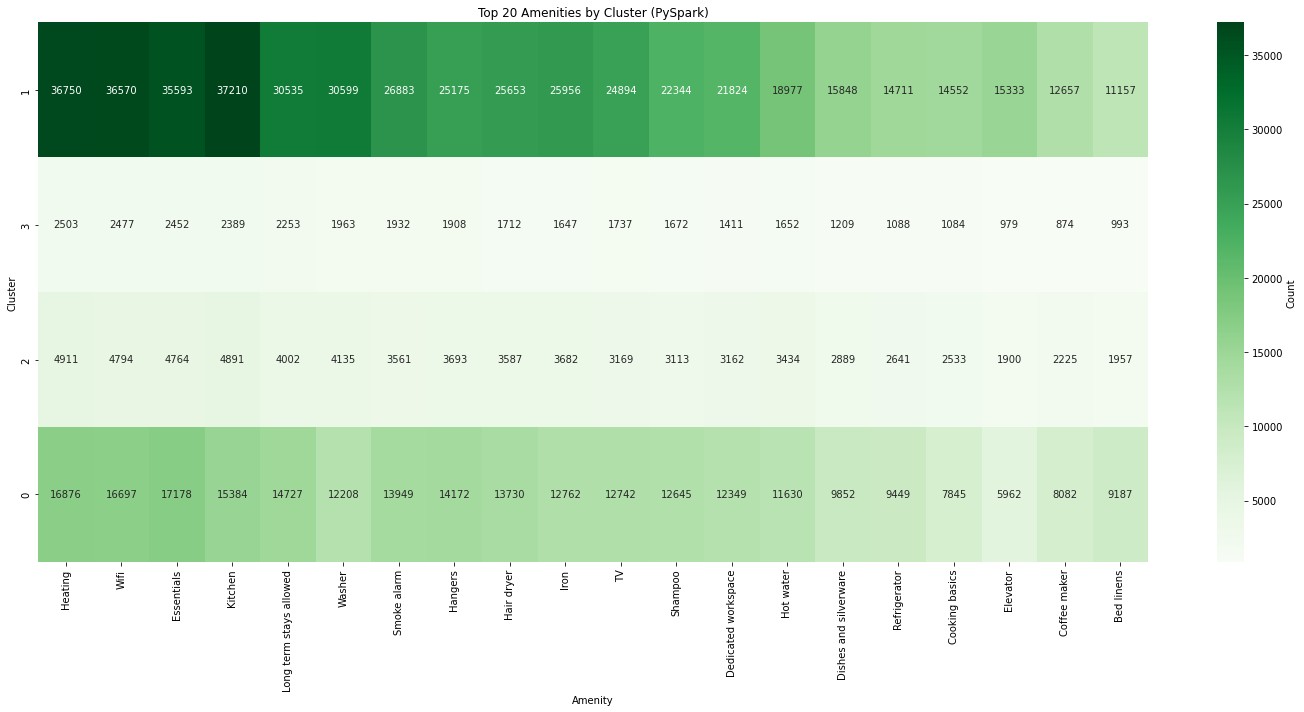

In [0]:
# Choose top N amenities to keep the heatmap readable
top_amenities = amenity_counts.groupBy("amenity").sum("count") \
    .orderBy("sum(count)", ascending=False).limit(20).toPandas()["amenity"].tolist()

heatmap_data = amenity_pivot_pd[top_amenities + ['prediction']].set_index('prediction')

plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap="Greens", cbar_kws={'label': 'Count'})
plt.title("Top 20 Amenities by Cluster (PySpark)")
plt.xlabel("Amenity")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


- **Cluster 1** dominates amenity availability across the board:
  - Has significantly higher counts for all top amenities.
  - Especially strong in core amenities like **Heating**, **Kitchen**, **WiFi**, and **Essentials**, indicating high-quality, well-prepared listings.
  - Suggests these hosts are highly professional or experienced.

- **Cluster 0** is the second strongest in amenity coverage:
  - Offers most of the same amenities as Cluster 1, though in lower volumes.
  - Represents hosts aiming for quality but possibly newer or less established.

- **Cluster 2** has moderate amenity presence:
  - Fewer listings overall, but still maintains decent coverage of essential amenities.
  - Likely hosts who are more selective or manage fewer properties.

- **Cluster 3** has the **lowest amenity coverage**:
  - Especially low in higher-end amenities like **Washer**, **Hair dryer**, **TV**, and **Refrigerator**.
  - Indicates lower-effort or more budget listings with basic offerings.

- **Heating**, **WiFi**, **Essentials**, and **Kitchen** are widely available across all clusters, but reach their **highest levels in Cluster 1**.
- This supports the idea that **Cluster 1 offers the most complete guest experience**, while **Cluster 3 offers the leanest setup**.
- Higher amenity availability seems to align closely with the **more professional/ideal clusters (1 and 0)**.
> Amenity distribution aligns closely with host behavior: the more responsive, experienced, and well-rated the cluster, the better-equipped the listings.


### 5.2 Amenities Perspective

__`Step 7`__ Make a Cluster Analysis based on the amenities available in the listing

#### 5.2.1 Cluster 

In [0]:
listing_perspective = list(amenity_categories.keys())

listing_perspective

Out[51]: ['living_entertainment',
 'kitchen_dining',
 'bedroom',
 'bathroom',
 'baby_family',
 'laundry_cleaning',
 'safety_security',
 'outdoor_garden',
 'heating_cooling',
 'travel_access',
 'wellness_leisure',
 'workspace_tech',
 'guest_services',
 'misc_essentials']

- Filling missing values with the mean - Amenities Perspective

In [0]:
# Impute each column with its median
for col_name in listing_perspective:
    # Calculate approximate median (50th percentile)
    median_val = df.approxQuantile(col_name, [0.5], 0.01)[0]
    
    # Fill missing values with the median
    df = df.fillna({col_name: median_val})

In [0]:
for column in listing_perspective:
    # Calculate Q1 and Q3
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter DataFrame
    df = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))   

In [0]:
assembler = VectorAssembler(
    inputCols=listing_perspective,
    outputCol="features"
)

df_features = assembler.transform(df)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaler_model = scaler.fit(df_features)
df_features = scaler_model.transform(df_features)



evaluator = ClusteringEvaluator()
inertias = []
silhouette_scores = []
k_values = list(range(2, 11)) 

for k in k_values:
    kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=42)
    model = kmeans.fit(df_features)
    predictions = model.transform(df_features)
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    # Inertia (WSSSE)
    inertia = model.summary.trainingCost
    inertias.append(inertia)

    print(f"k={k}, silhouette score={silhouette:.4f}")

k=2, silhouette score=0.4544
k=3, silhouette score=0.3875
k=4, silhouette score=0.3626
k=5, silhouette score=0.2583
k=6, silhouette score=0.2277
k=7, silhouette score=0.1908
k=8, silhouette score=0.1329
k=9, silhouette score=0.1791
k=10, silhouette score=0.1653


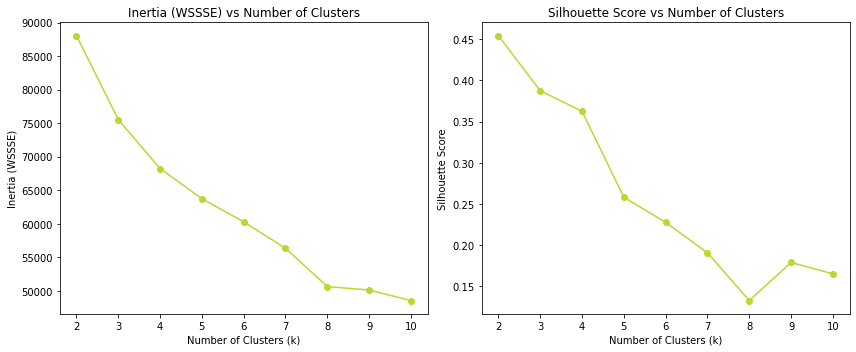

In [0]:
plt.figure(figsize=(12, 5))

# Inertia Plot
plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, marker='o', color=main_palette[0])
plt.title('Inertia (WSSSE) vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WSSSE)')

# Silhouette Score Plot
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color=main_palette[0])
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [0]:
kmeans = KMeans(featuresCol="scaledFeatures",predictionCol="prediction", k=3)
model = kmeans.fit(df_features)

# Make predictions
predictions = model.transform(df_features)

df_scaled_array = predictions.withColumn("scaledF", vector_to_array("scaledFeatures"))

for i, feat in enumerate(listing_perspective):
    df_scaled_array = df_scaled_array.withColumn(f"scaled_{feat}", col("scaledF")[i])
scaled_cols = [col_name for col_name in df_scaled_array.columns if col_name.startswith("scaled_") and not col_name.startswith("scaledF") ]

scaled_cols.append("prediction")

df_features=df_scaled_array.select(scaled_cols)

df_features.show(5)

+---------------------------+---------------------+-------------------+--------------------+------------------+-----------------------+----------------------+---------------------+----------------------+--------------------+-----------------------+---------------------+---------------------+----------------------+----------+
|scaled_living_entertainment|scaled_kitchen_dining|     scaled_bedroom|     scaled_bathroom|scaled_baby_family|scaled_laundry_cleaning|scaled_safety_security|scaled_outdoor_garden|scaled_heating_cooling|scaled_travel_access|scaled_wellness_leisure|scaled_workspace_tech|scaled_guest_services|scaled_misc_essentials|prediction|
+---------------------------+---------------------+-------------------+--------------------+------------------+-----------------------+----------------------+---------------------+----------------------+--------------------+-----------------------+---------------------+---------------------+----------------------+----------+
|         -1.348933

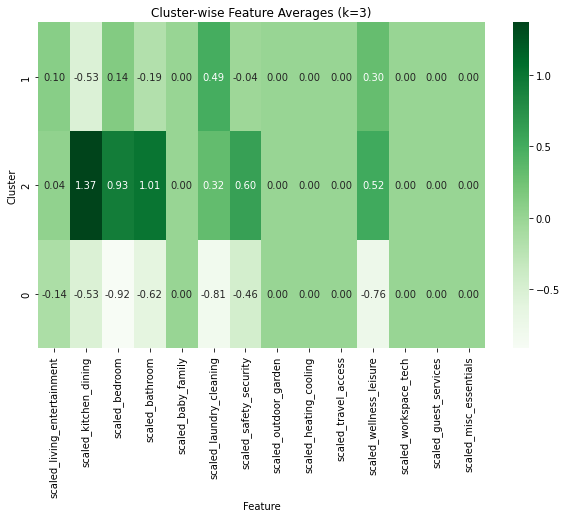

In [0]:
# Group by 'prediction' and compute the average for each scaled feature
agg_exprs = [F.avg(col_name).alias(col_name) for col_name in scaled_cols if col_name != "prediction"]

df_avg = df_features.groupBy("prediction").agg(*agg_exprs)

pandas_avg = df_avg.toPandas().set_index("prediction")


plt.figure(figsize=(10, 6))
sns.heatmap(pandas_avg, annot=True, cmap="Greens", fmt=".2f")
plt.title("Cluster-wise Feature Averages (k=3)")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.show()

%md
🧠 Cluster Interpretations:

#Cluster 0:
Strong negatives in:

>scaled_kitchen_dining (–0.53)

>scaled_bedroom (–0.92)

>scaled_baby_family (–0.81)

>scaled_wellness_leisure (–0.76)

##Interpretation:

Homes in this cluster are less equipped in terms of bedrooms, baby/family features, kitchen/dining areas, and leisure/wellness amenities.

Possibly small or minimalistic properties (e.g., studios or small apartments).

##Cluster 1:
Values mostly near 0 (neutral), small positives for:

>scaled_baby_family (0.49)

>scaled_laundry_cleaning (0.32)

##Interpretation:

This is a moderate or baseline cluster, with average feature presence across the board.

Could represent balanced listings without strong deviations.

##Cluster 2:
Strong positives in:

>scaled_kitchen_dining (1.37)

>scaled_bedroom (0.93)

Also elevated in:

>scaled_outdoor_garden (0.52)

>scaled_baby_family (0.60)

>scaled_wellness_leisure (0.30)

##Interpretation:

  These are well-equipped or spacious properties with ample bedrooms, kitchen space, garden access, and family amenities.

  Likely premium or family-friendly homes.

| Cluster | Characteristics                                                     |
| ------- | ------------------------------------------------------------------- |
| **0**   | Minimalist/small homes (low in space, family, and leisure features) |
| **1**   | Average/balanced properties with no standout features               |
| **2**   | Spacious, family- and leisure-oriented homes (well-equipped)        |


__`Step 8`__ Use non-metrical features to help understand the profile of these clusters

#### 5.2.2 Cluster Profilling

In [0]:
# Add an index column to both DataFrames
df = df.withColumn("row_id", monotonically_increasing_id())
df_features = df_features.withColumn("row_id", monotonically_increasing_id())

# Join by the synthetic row index
df_with_prediction = df.join(df_features.select('row_id', 'prediction'), on='row_id', how='left') \
                       .drop('row_id') 

df_with_prediction.show(5)

+----------+--------------------+--------+----------+--------------------+------------------+------------------+--------------------+-----------------+-------------------------+--------------------+----------------------+-----------------+--------+-----+--------+---------+----------------+------------+------------+--------+--------------------+-----+--------------+--------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+----------------+--------------------+----------------------+--------------------+--------------------+-------------------+-------------------+-----------+----------------+-------------------+--------------+------------------+------------------+-------------------+------------------+--------------+---------------+---------------+---------+----------+
|listing_id|                name| host_id|host_since|       host_location|host_response_time|host_resp

In [0]:
cluster_counts = df_with_prediction.groupBy('neighbourhood', 'prediction').count()

display(cluster_counts)

neighbourhood,prediction,count
Opera,0,255
Reuilly,0,237
Menilmontant,1,390
Palais-Bourbon,0,122
Buttes-Montmartre,0,791
Elysee,0,111
Louvre,0,84
Gobelins,2,151
Vaugirard,2,317
Pantheon,1,194


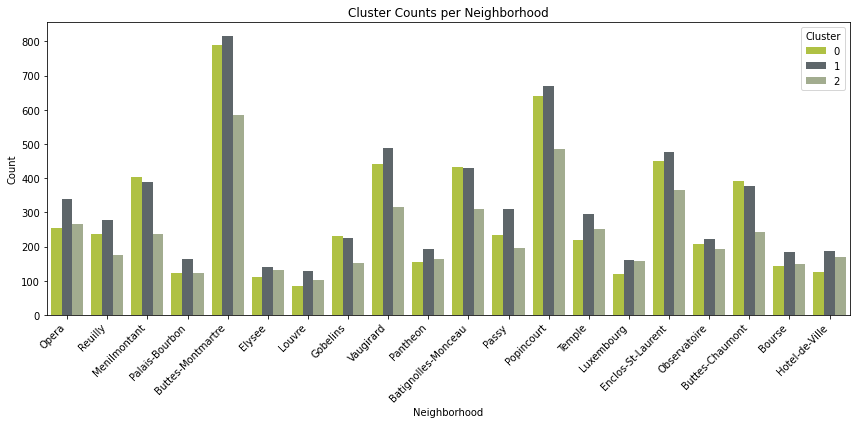

In [0]:
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_counts.toPandas(), x='neighbourhood', y='count', hue='prediction',palette=main_palette)
plt.title("Cluster Counts per Neighborhood")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Neighborhood")
plt.ylabel("Count")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [0]:
display(df_with_prediction.limit(5))

listing_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,district,city,latitude,longitude,property_type,room_type,accommodates,bedrooms,amenities,price,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,amenities_array,standardized_amenities,living_entertainment,kitchen_dining,bedroom,bathroom,baby_family,laundry_cleaning,safety_security,outdoor_garden,heating_cooling,travel_access,wellness_leisure,workspace_tech,guest_services,misc_essentials,days_since_host,row_index,prediction
3705183,39 mÂ² Paris (Sacre CÅ“ur),10328771,2013-11-29,"Paris, Ile-de-France, France",null,1.0,0.97,f,1,t,t,Buttes-Montmartre,null,Paris,48.88617,2.34515,Entire apartment,Entire place,2,1,"[""Shampoo"", ""Heating"", ""Kitchen"", ""Essentials"", ""Washer"", ""Dryer"", ""Wifi"", ""Long term stays allowed""]",120,2,1125,100,10,10,10,10,10,10,f,"List(Shampoo, Heating, Kitchen, Essentials, Washer, Dryer, Wifi, Long term stays allowed)","List(washer, wifi, heating, shampoo, essentials, long term stays allowed, dryer, kitchen)",0.0,0.034482758620689655,0.0,0.08333333333333333,0.0,0.2,0.0,0.0,0.1111111111111111,0.1111111111111111,0.0,0.1111111111111111,0.0,0.25,2627,1,0
4823489,Close to Eiffel Tower - Beautiful flat : 2 rooms,24837558,2014-12-14,"Paris, Ile-de-France, France",null,1.0,0.97,f,1,t,f,Passy,null,Paris,48.855,2.26979,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Hair dryer"", ""Washer"", ""Dryer"", ""Bathtub"", ""Wifi"", ""Elevator"", ""Long term stays allowed"", ""Cable TV""]",60,2,1125,100,10,10,10,10,10,10,f,"List(Heating, TV, Kitchen, Essentials, Hair dryer, Washer, Dryer, Bathtub, Wifi, Elevator, Long term stays allowed, Cable TV)","List(washer, wifi, elevator, heating, essentials, tv, long term stays allowed, dryer, bathtub, kitchen)",0.05555555555555555,0.034482758620689655,0.0,0.08333333333333333,0.0,0.2,0.0,0.0,0.1111111111111111,0.1111111111111111,0.0,0.1111111111111111,0.0,0.25,2247,4,0
4898654,NEW - Charming apartment Le Marais,505535,2011-04-13,"Paris, Ile-de-France, France",null,1.0,0.97,f,1,t,t,Temple,null,Paris,48.86428,2.3537,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Washer"", ""Smoke alarm"", ""Wifi"", ""Long term stays allowed"", ""Cable TV""]",95,2,1125,100,10,10,10,10,10,10,f,"List(Heating, TV, Kitchen, Essentials, Washer, Smoke alarm, Wifi, Long term stays allowed, Cable TV)","List(washer, wifi, heating, smoke alarm, essentials, tv, long term stays allowed, kitchen)",0.05555555555555555,0.034482758620689655,0.0,0.0,0.0,0.1,0.07692307692307693,0.0,0.1111111111111111,0.1111111111111111,0.0,0.1111111111111111,0.0,0.25,3588,5,0
6945740,57sqm btw. Bastille & PÃ¨re Lachaise,5924709,2013-04-14,"Paris, Ile-de-France, France",null,1.0,0.97,f,1,t,t,Popincourt,null,Paris,48.86043,2.37842,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Washer"", ""Dryer"", ""Smoke alarm"", ""Wifi"", ""Long term stays allowed""]",59,2,1125,100,10,10,10,10,10,10,f,"List(Heating, TV, Kitchen, Essentials, Washer, Dryer, Smoke alarm, Wifi, Long term stays allowed)","List(washer, wifi, heating, smoke alarm, essentials, tv, long term stays allowed, dryer, kitchen)",0.05555555555555555,0.034482758620689655,0.0,0.0,0.0,0.2,0.07692307692307693,0.0,0.1111111111111111,0.1111111111111111,0.0,0.1111111111111111,0.0,0.25,2856,7,0
7849932,Bel appartement plein de charme !,20833291,2014-09-02,"Paris, Ile-de-France, France",null,1.0,0.97,f,1,t,t,Opera,null,Paris,48.8779,2.33122,Entire apartment,Entire place,2,1,"[""Heating"", ""TV"", ""Iron"", ""Kitchen"", ""Essentials"", ""Hair dryer"", ""Washer"", ""Hangers"", ""Wifi"", ""Elevator"", ""Lo

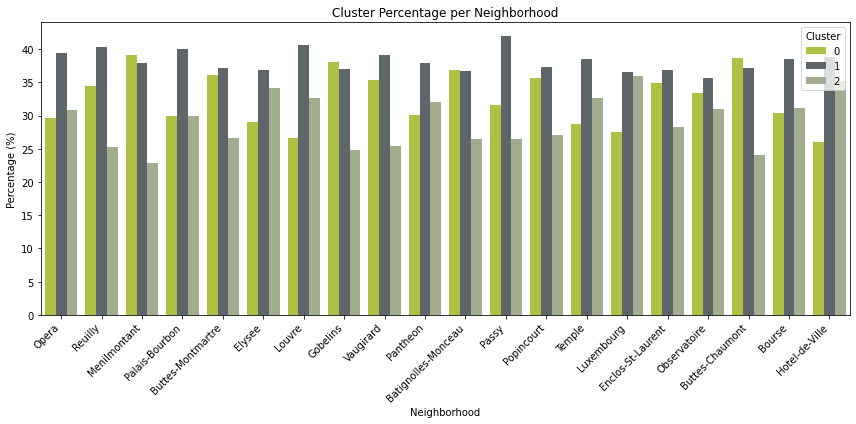

In [0]:
pdf = cluster_counts.toPandas()

pdf['percentage'] = pdf.groupby('neighbourhood')['count'].transform(lambda x: x / x.sum() * 100)

plt.figure(figsize=(12, 6))
sns.barplot(data=pdf, x='neighbourhood', y='percentage', hue='prediction', palette=main_palette)
plt.title("Cluster Percentage per Neighborhood")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Neighborhood")
plt.ylabel("Percentage (%)")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()



###### Neighborhoods Dominated by **Cluster 1** (Average Homes)
- **Opera**, **Palais-Bourbon**, **Louvre**, **Gobelins**, **Pantheon**, **Popincourt**
  - Cluster 1 exceeds 40% in these areas.
  - Indicative of **balanced, standard housing** — neither very small nor particularly luxurious.

---

######  Neighborhoods with Higher **Cluster 2** (Spacious, Family-Friendly Homes)
- **Buttes-Chaumont**, **Observatoire**, **Reuilly**, **Hotel-de-Ville**
  - Higher than average share of Cluster 2 (~35%+).
  - Suggests **better options for families**, more spacious and well-equipped housing.

---

##### Neighborhoods Skewed Toward **Cluster 0** (Minimalist/Compact Homes)
- **Elysee**, **Menilmontant**, **Buttes-Montmartre**, **Vaugirard**, **Bourse**
  - High percentage of Cluster 0 (often 35–40%+).
  - Reflects **more compact, possibly high-density urban housing** — may suit singles or young professionals.

---